In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/data-science-bowl-2019/sample_submission.csv
/kaggle/input/data-science-bowl-2019/specs.csv
/kaggle/input/data-science-bowl-2019/train_labels.csv
/kaggle/input/data-science-bowl-2019/train.csv
/kaggle/input/data-science-bowl-2019/test.csv


In [2]:
train = pd.read_csv('/kaggle/input/data-science-bowl-2019/train.csv')
test = pd.read_csv('/kaggle/input/data-science-bowl-2019/test.csv')
label = pd.read_csv('/kaggle/input/data-science-bowl-2019/train_labels.csv')

In [3]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


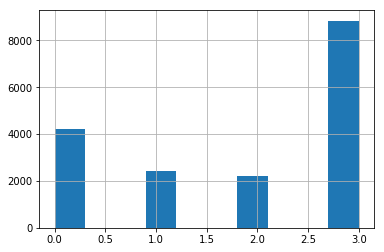

In [4]:
label['accuracy_group'].hist()

In [5]:
label.groupby(['installation_id']).count()

,game_session,title,num_correct,num_incorrect,accuracy,accuracy_group
installation_id,,,,,,
0006a69f,5,5,5,5,5,5
0006c192,3,3,3,3,3,3
00129856,1,1,1,1,1,1
001d0ed0,5,5,5,5,5,5
00225f67,1,1,1,1,1,1
...,...,...,...,...,...,...
ff9305d7,4,4,4,4,4,4
ff9715db,9,9,9,9,9,9
ffc90c32,6,6,6,6,6,6


In [6]:
train.timestamp=pd.to_datetime(train['timestamp'])

**Firstly, using 'event_id' as sequenctial input to predict the accuracy-group of each assessment game.

In [7]:
from more_itertools import sliced
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks.callbacks import EarlyStopping

Using TensorFlow backend.


In [8]:
merged = train.merge(label, how='inner', on=['installation_id','game_session'])
train_data = merged[['installation_id','game_session','event_code']]
train_data['event_code'] = train_data['event_code'].apply(str)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
def events_add(event_code):
    event_list = ''
    for i in event_code: 
        event_list += i + ' '
    event_list = event_list.rstrip()
    return event_list

In [10]:
train_data['event_code']

0         2000
1         2025
2         3010
3         3110
4         3010
          ... 
865442    2030
865443    4025
865444    3021
865445    3121
865446    2010
Name: event_code, Length: 865447, dtype: object

In [11]:
game_sequence = train_data.groupby(['installation_id','game_session']).sum().reset_index()
game_sequence['event_code'] = game_sequence['event_code'].apply(lambda x: list(sliced(x, 4)))
game_sequence['event_sequence'] = game_sequence['event_code'].apply(events_add)
game_sequence = game_sequence.merge(label, how='inner', on=['installation_id','game_session'])[['event_sequence','accuracy_group']]

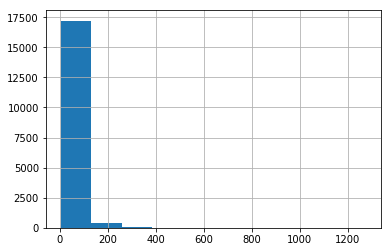

In [12]:
k = train_data.groupby(['installation_id','game_session']).count()
k['event_code'].hist()

In [13]:
game_sequence

,event_sequence,accuracy_group
0,2000 2025 3010 4070 4025 3110 3021 3121 4025 3...,3
1,2000 2020 3010 3110 4030 4025 4030 4025 4030 4...,0
2,2000 2025 3010 3110 3010 4025 3110 3021 3121 4...,3
3,2000 2025 3010 4025 3110 3021 3121 4025 3021 3...,2
4,2000 2020 3010 4030 4025 3110 4030 4025 4070 4...,3
...,...,...
17685,2000 2020 3010 4030 4070 3110 4030 4025 4070 4...,3
17686,2000 3010 2020 3110 4070 4070 4030 4040 4030 4...,3
17687,2000 3010 2020 3110 4070 4070 4030 4020 4030 4...,1
17688,2000 2025 3010 3110 3010 3110 4070 4025 3021 3...,0


In [14]:
sum(game_sequence['event_sequence']=='2000')

0

Making the sequence limited to 400.

In [15]:
MAX_NB_WORDS = 200
MAX_SEQUENCE_LENGTH = 400
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(game_sequence['event_sequence'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 22 unique tokens.


In [16]:
X = tokenizer.texts_to_sequences(game_sequence['event_sequence'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (17690, 400)


In [17]:
Y = pd.get_dummies(game_sequence['accuracy_group']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (17690, 4)


In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 1)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(15036, 400) (15036, 4)
(2654, 400) (2654, 4)


In [19]:
model0 = Sequential()
model0.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model0.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2))
model0.add(Dense(4, activation='softmax'))
model0.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model0.fit(X_train, Y_train, epochs= 5, batch_size=64,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)])

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 13532 samples, validate on 1504 samples
Epoch 1/5
13532/13532 [==============================] - 72s 5ms/step - loss: 0.5467 - accuracy: 0.8066 - val_loss: 0.2522 - val_accuracy: 0.9235
Epoch 2/5
13532/13532 [==============================] - 71s 5ms/step - loss: 0.2149 - accuracy: 0.9282 - val_loss: 0.1511 - val_accuracy: 0.9488
Epoch 3/5
13532/13532 [==============================] - 69s 5ms/step - loss: 0.1448 - accuracy: 0.9554 - val_loss: 0.0898 - val_accuracy: 0.9794
Epoch 4/5
13532/13532 [==============================] - 70s 5ms/step - loss: 0.0957 - accuracy: 0.9749 - val_loss: 0.0612 - val_accuracy: 0.9834
Epoch 5/5
13532/13532 [==============================] - 70s 5ms/step - loss: 0.1059 - accuracy: 0.9724 - val_loss: 0.0508 - val_accuracy: 0.9894


In [20]:
accuracy = model0.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.5f}\n  Accuracy: {:0.5f}'.format(accuracy[0],accuracy[1]))

2654/2654 [==============================] - 5s 2ms/step
Test set
  Loss: 0.04866
  Accuracy: 0.99020


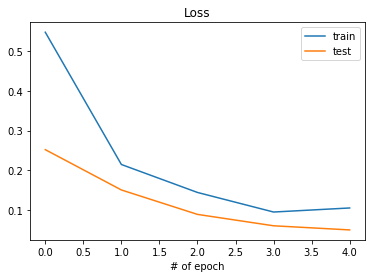

In [21]:
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.title('Loss')
plt.xlabel('# of epoch')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Now using the hierachical clustering to assign each 'installation_id' an 'accuracy_group'

In [22]:
average_accuracy = round(label.groupby('installation_id').mean()['accuracy_group']).apply(int).reset_index()

In [23]:
average_accuracy['Bird Measurer (Assessment)'] = np.nan
average_accuracy['Cart Balancer (Assessment)'] = np.nan
average_accuracy['Cauldron Filler (Assessment)'] = np.nan
average_accuracy['Chest Sorter (Assessment)'] = np.nan
average_accuracy['Mushroom Sorter (Assessment)'] = np.nan

In [24]:
for i in average_accuracy.installation_id:
    a = label.loc[label['installation_id']==i]['title']
    for j in a:
        average_accuracy[j][average_accuracy['installation_id'] == i] = list(label.loc[(label['installation_id'] == i) & (label['title'] == j)]['accuracy_group'])[0]
        

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8130c0a58>,
      dtype=object)

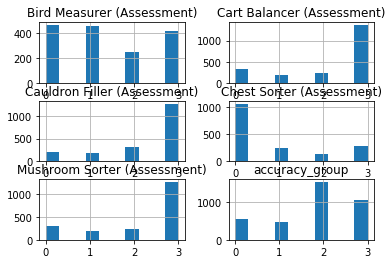

In [25]:
average_accuracy.hist()

In [26]:
append = {}
for i in ['Bird Measurer (Assessment)',
       'Cart Balancer (Assessment)', 'Cauldron Filler (Assessment)',
       'Chest Sorter (Assessment)', 'Mushroom Sorter (Assessment)']:
    append[i] = average_accuracy[i].median()
    average_accuracy[i][average_accuracy[i].isnull()] = round(average_accuracy[i].mean())
    

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
average_accuracy

,installation_id,accuracy_group,Bird Measurer (Assessment),Cart Balancer (Assessment),Cauldron Filler (Assessment),Chest Sorter (Assessment),Mushroom Sorter (Assessment)
0,0006a69f,2,0.0,2.0,2.0,1.0,3.0
1,0006c192,2,2.0,2.0,3.0,1.0,0.0
2,00129856,3,3.0,2.0,2.0,1.0,2.0
3,001d0ed0,2,0.0,3.0,2.0,0.0,2.0
4,00225f67,0,0.0,2.0,2.0,1.0,2.0
...,...,...,...,...,...,...,...
3609,ff9305d7,0,1.0,2.0,2.0,0.0,2.0
3610,ff9715db,2,1.0,3.0,3.0,1.0,3.0
3611,ffc90c32,3,3.0,3.0,3.0,3.0,3.0
3612,ffd2871d,3,1.0,2.0,3.0,1.0,2.0


In [28]:
KM_x = average_accuracy[['Bird Measurer (Assessment)','Cart Balancer (Assessment)','Cauldron Filler (Assessment)',
                        'Chest Sorter (Assessment)','Mushroom Sorter (Assessment)']]
KM_y = average_accuracy['accuracy_group']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd7b8a7ef28>]],
      dtype=object)

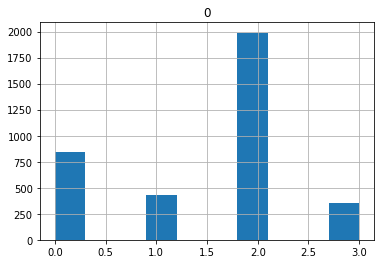

In [29]:
from sklearn.cluster import AgglomerativeClustering 

 
model=AgglomerativeClustering(n_clusters=4,linkage='ward')

model.fit(KM_x)
model.labels_
pd.DataFrame(model.labels_).hist()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doi

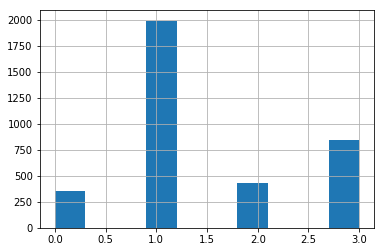

In [30]:
average_accuracy['accuracy_group'][model.labels_ == 0] = 3
average_accuracy['accuracy_group'][model.labels_ == 1] = 2
average_accuracy['accuracy_group'][model.labels_ == 2] = 1
average_accuracy['accuracy_group'][model.labels_ == 3] = 0
average_accuracy['accuracy_group'].hist()

In [31]:
test_assessment = test[test.type == 'Assessment']

In [32]:
test_assessment

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
282,7ad3efc6,8b38fc0d2fd315dc,2019-09-11T18:56:11.918Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",00abaee7,1,2000,0,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
283,65a38bf7,8b38fc0d2fd315dc,2019-09-11T18:56:12.019Z,"{""crystals"":[{""id"":""gem07"",""weight"":6},{""id"":""...",00abaee7,2,2020,58,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
284,795e4a37,8b38fc0d2fd315dc,2019-09-11T18:56:12.030Z,"{""description"":""We've got to balance this scal...",00abaee7,3,3010,58,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
285,5e109ec3,8b38fc0d2fd315dc,2019-09-11T18:56:15.790Z,"{""crystal_id"":""gem07"",""weight"":6,""coordinates""...",00abaee7,4,4030,3852,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
286,5c2f29ca,8b38fc0d2fd315dc,2019-09-11T18:56:17.869Z,"{""crystal_id"":""gem07"",""weight"":6,""coordinates""...",00abaee7,5,4020,5968,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
...,...,...,...,...,...,...,...,...,...,...,...
1156408,9d29771f,46ff9d3ad2be09f2,2019-09-28T21:20:36.723Z,"{""description"":""Alright! This one is the littl...",ffe774cc,38,3021,27797,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
1156409,c74f40cd,46ff9d3ad2be09f2,2019-09-28T21:20:40.918Z,"{""description"":""Alright! This one is the littl...",ffe774cc,39,3121,32030,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
1156410,6c930e6e,46ff9d3ad2be09f2,2019-09-28T21:20:41.493Z,"{""duration"":20008,""misses"":0,""event_count"":40,...",ffe774cc,40,2030,32584,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
1156411,a5be6304,46ff9d3ad2be09f2,2019-09-28T21:20:45.499Z,"{""session_duration"":36607,""exit_type"":""game_co...",ffe774cc,41,2010,36607,Mushroom Sorter (Assessment),Assessment,TREETOPCITY


In [33]:
test_assessment['game_session'].unique().size

3347

In [34]:
test_assessment['installation_id'].unique().size

1000

In [35]:
count_game = test_assessment.groupby(['installation_id','game_session']).count().reset_index()
count_game = count_game[count_game.event_id > 1]
count_game = count_game['game_session']

In [36]:
test_data = test_assessment[['event_code','installation_id','game_session','title']]
#test_data = test_data[test_data.game_session.isin(count_game)]
test_data['event_code'] = test_data['event_code'].apply(str)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
test_game_sequence = test_data.groupby(['installation_id','game_session','title']).sum().reset_index()
test_game_sequence['event_code'] = test_game_sequence['event_code'].apply(lambda x: list(sliced(x, 4)))
test_game_sequence['event_sequence'] = test_game_sequence['event_code'].apply(events_add)
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(test_game_sequence['event_sequence'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 22 unique tokens.


In [38]:
X_test = tokenizer.texts_to_sequences(test_game_sequence['event_sequence'].values)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_test.shape)
X_test

Shape of data tensor: (3347, 400)


array([[ 0,  0,  0, ...,  0,  0, 10],
       [ 0,  0,  0, ...,  8, 15, 17],
       [ 0,  0,  0, ...,  7,  8, 17],
       ...,
       [ 0,  0,  0, ...,  6,  4,  6],
       [ 0,  0,  0, ...,  8, 15, 17],
       [ 0,  0,  0, ...,  0,  0, 10]], dtype=int32)

In [39]:
test_pred = pd.DataFrame(model0.predict(X_test)).idxmax(1)

In [40]:
test_pred

0       0
1       3
2       3
3       0
4       2
       ..
3342    3
3343    0
3344    3
3345    2
3346    0
Length: 3347, dtype: int64

In [41]:
test_game_sequence['accuracy_group'] = test_pred

In [42]:
test_game_sequence

,installation_id,game_session,title,event_code,event_sequence,accuracy_group
0,00abaee7,348d7f09f96af313,Cauldron Filler (Assessment),[2000],2000,0
1,00abaee7,8b38fc0d2fd315dc,Cart Balancer (Assessment),"[2000, 2020, 3010, 4030, 4020, 3110, 4030, 402...",2000 2020 3010 4030 4020 3110 4030 4020 4070 4...,3
2,01242218,009c890ce6c4f3e3,Cauldron Filler (Assessment),"[2000, 3010, 2020, 4070, 4030, 3110, 4020, 403...",2000 3010 2020 4070 4030 3110 4020 4030 4020 4...,3
3,01242218,1fef5d54cb4b775a,Cart Balancer (Assessment),[2000],2000,0
4,01242218,31423dbcd717919e,Mushroom Sorter (Assessment),"[2000, 2025, 3010, 3110, 3010, 4025, 3110, 302...",2000 2025 3010 3110 3010 4025 3110 3021 3121 4...,2
...,...,...,...,...,...,...
3342,ffe00ca8,70336ec581799feb,Cauldron Filler (Assessment),"[2000, 3010, 2020, 4070, 4100, 3110, 3020, 312...",2000 3010 2020 4070 4100 3110 3020 3120 4030 4...,3
3343,ffe00ca8,8d0fdec0ad44aefb,Cart Balancer (Assessment),[2000],2000,0
3344,ffe00ca8,c116d9e6f8cf85c3,Cauldron Filler (Assessment),"[2000, 3010, 2020, 4070, 4070, 4070, 4070, 311...",2000 3010 2020 4070 4070 4070 4070 3110 4070 4...,3
3345,ffe774cc,46ff9d3ad2be09f2,Mushroom Sorter (Assessment),"[2000, 2025, 3010, 3110, 3010, 4025, 3110, 302...",2000 2025 3010 3110 3010 4025 3110 3021 3121 4...,2


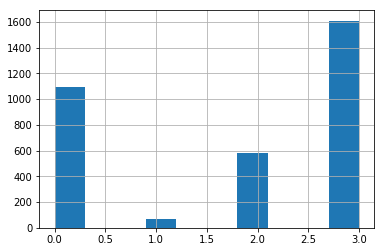

In [43]:
test_game_sequence['accuracy_group'].hist()

In [44]:
test_accuracy = pd.DataFrame(test_assessment['installation_id'].unique(),columns = ['installation_id'])
test_accuracy['Bird Measurer (Assessment)'] = np.nan
test_accuracy['Cart Balancer (Assessment)'] = np.nan
test_accuracy['Cauldron Filler (Assessment)'] = np.nan
test_accuracy['Chest Sorter (Assessment)'] = np.nan
test_accuracy['Mushroom Sorter (Assessment)'] = np.nan
test_accuracy['accuracy_group'] = np.nan
for i in test_accuracy.installation_id:
    a = test_game_sequence.loc[test_game_sequence['installation_id']==i]['title']
    for j in a:
        test_accuracy[j][test_accuracy['installation_id'] == i] = list(test_game_sequence.loc[(test_game_sequence['installation_id'] == i) & (test_game_sequence['title'] == j)]['accuracy_group'])[0]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd7b84dc400>,
      dtype=object)

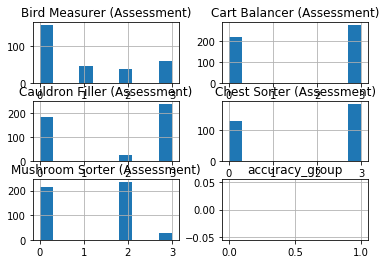

In [45]:
test_accuracy.hist()

In [46]:
for i in ['Bird Measurer (Assessment)',
       'Cart Balancer (Assessment)', 'Cauldron Filler (Assessment)',
       'Chest Sorter (Assessment)', 'Mushroom Sorter (Assessment)']:
    test_accuracy[i][test_accuracy[i].isnull()] = round(average_accuracy[i].mean())


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd7b75687f0>,
      dtype=object)

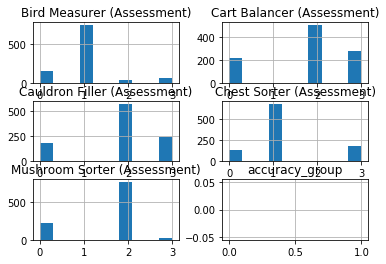

In [47]:
test_accuracy.hist()

In [48]:
test_x = test_accuracy[['Bird Measurer (Assessment)','Cart Balancer (Assessment)','Cauldron Filler (Assessment)',
                        'Chest Sorter (Assessment)','Mushroom Sorter (Assessment)']]
test_id_pred = pd.Series(model.fit_predict(test_x))


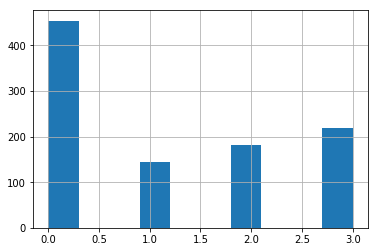

In [49]:
test_id_pred.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd7b72a99b0>,
      dtype=object)

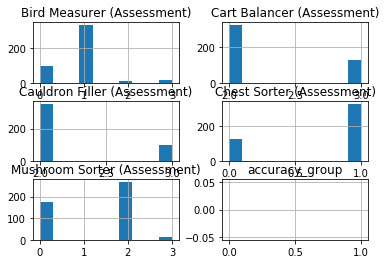

In [50]:
k = test_accuracy[test_id_pred == 0]
k.hist()

In [51]:
test_accuracy['accuracy_group'][test_id_pred == 0] = '3'
test_accuracy['accuracy_group'][test_id_pred == 1] = '2'
test_accuracy['accuracy_group'][test_id_pred == 2] = '1'
test_accuracy['accuracy_group'][test_id_pred == 3] = '0'

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [52]:
submission = test_accuracy[['installation_id','accuracy_group']]

In [53]:
submission.to_csv('submission.csv', index=False)